In [5]:
from __future__ import annotations

from typing import TYPE_CHECKING

from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

True

In [6]:
from typing import (
    Any,
    AsyncIterator,
    Dict,
    Iterable,
    Iterator,
    List,
    Optional,
    Sequence,
    cast,
)
import rich
from sandbox_agent import debugger
from langchain_core.runnables.schema import StreamEvent


class AnyStr(str):
    def __eq__(self, other: Any) -> bool:
        return isinstance(other, str)


def _with_nulled_run_id(events: Sequence[StreamEvent]) -> List[StreamEvent]:
    """Removes the run ids from events."""
    for event in events:
        assert "run_id" in event, f"Event {event} does not have a run_id."
        assert "parent_ids" in event, f"Event {event} does not have parent_ids."
        assert isinstance(
            event["run_id"], str
        ), f"Event {event} run_id is not a string."
        assert isinstance(
            event["parent_ids"], list
        ), f"Event {event} parent_ids is not a list."

    return cast(
        List[StreamEvent],
        [{**event, "run_id": "", "parent_ids": []} for event in events],
    )


async def _as_async_iterator(iterable: List) -> AsyncIterator:
    """Converts an iterable into an async iterator."""
    for item in iterable:
        yield item


async def _collect_events(
    events: AsyncIterator[StreamEvent], with_nulled_ids: bool = True
) -> List[StreamEvent]:
    """Collect the events and remove the run ids."""
    materialized_events = [event async for event in events]

    if with_nulled_ids:
        events_ = _with_nulled_run_id(materialized_events)
    else:
        events_ = materialized_events
    for event in events_:
        event["tags"] = sorted(event["tags"])
    return events_

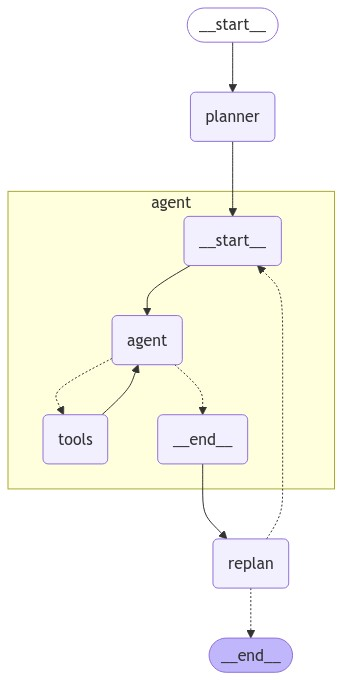

In [7]:
from sandbox_agent.ai.workflows import WorkflowFactory

workflow = WorkflowFactory.create()
# workflow.pretty_print()


from IPython.display import Image, display

display(Image(workflow.get_graph(xray=True).draw_mermaid_png()))

In [17]:
from rich.jupyter import print as rprint
from rich.__main__ import make_test_card
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme({
    "inspect.attr_name": "bold magenta",
    "inspect.attr_value": "green",
    "inspect.callable_name": "bold cyan",
    "inspect.callable_value": "blue",
    "inspect.error": "red",
    "inspect.help": "dim",
    "inspect.number": "yellow",
    "inspect.string": "italic green",
})

console = Console(soft_wrap=False, style="magenta", width=220, height=40, theme=custom_theme)
# console.print(workflow)
rich.inspect(workflow, console=console, all=True)

╭─────────────────────────────────────────────────────────────────────────────────── <class 'langgraph.graph.state.CompiledStateGraph'> ───────────────────────────────────────────────────────────────────────────────────╮
│ ╭──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ <langgraph.graph.state.CompiledStateGraph object at 0x1277c6150>                                                                                                                                                     │ │
│ ╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                                                                                                                                                          │
│                      _abc_impl = <_abc._abc_data object at 0x1222065c0>                                                                                                                                                  │
│            __abstractmethods__ = frozenset()                                                                                                                                                                             │
│                __annotations__ = {'builder': <class 'langgraph.graph.state.StateGraph'>}                                                                                                                                 │
│                        builder = <langgraph.graph.state.StateGraph object at 0x1274c76e0>                                                                                                                                │
│                       channels = {                                                                                                                                                                                       │
│                                      'input': <langgraph.channels.last_value.LastValue object at 0x1329523c0>,                                                                                                           │
│                                      'plan': <langgraph.channels.last_value.LastValue object at 0x1274a6400>,                                                                                                            │
│                                      'past_steps': <langgraph.channels.binop.BinaryOperatorAggregate object at 0x1274a5700>,                                                                                             │
│                                      'response': <langgraph.channels.last_value.LastValue object at 0x1274c1f00>,                                                                                                        │
│                                      '__start__': <langgraph.channels.ephemeral_value.EphemeralValue object at 0x13295b680>,                                                                                             │
│                                      'planner': <langgraph.channels.ephemeral_value.EphemeralValue object at 0x1329601c0>,                                                                                               │
│                                      'agent': <langgraph.channels.ephemeral_value.EphemeralValue object at 0x1273a9e80>,                                                                                                 │
│                                      'replan': <langgraph.channels.ephemeral_value.EphemeralValue object at 0x127333040>,                                                                                                │
│                     

In [4]:
config = {"recursion_limit": 50}
inputs = {"input": "what is the hometown of the mens 2024 Australia open winner?"}
async for event in workflow.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ["Identify the winner of the men's 2024 Australian Open.", 'Research the hometown of the identified winner.']}
{'past_steps': [("Identify the winner of the men's 2024 Australian Open.", "The winner of the men's 2024 Australian Open is Jannik Sinner.")]}


ValidationError: 1 validation error for Act
action
  Field required [type=missing, input_value={'steps': ['Research the ...own of Jannik Sinner.']}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/missing